In [1]:
"""
Convert building footprints to centroid and sample the image stack
"""

# Packages
import os, time, sys
from os.path import join
import geopandas as gpd
import pandas as pd
import rasterio as rio
import seaborn as sns
import gc

print(os.getcwd())
maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping/'

# Custom functions
sys.path.append(os.getcwd())
import __functions
from __functions import *

# Coordinate Ref. System
proj = 32618  # UTM Zone 18N

print("Ready !!!")

/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping/code
Ready !!!


In [2]:
# Sample the footprint data !!

In [2]:
# Reference data (footprints)
ref_fp = join(maindir, 'data/spatial/mod/dc_data/training/dc_data_reference_footprints.gpkg')
# Image data (see psscene-prep.ipynb)
stack_fp = join(maindir,'data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b_final_norm.tif')
print(f'Reference file path: {ref_fp};\nImage file path: {stack_fp}')

Reference file path: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping/data/spatial/mod/dc_data/training/dc_data_reference_footprints.gpkg;
Image file path: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping/data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b_final_norm.tif


In [12]:
t0 = time.time()

# Create the band stats class
band_stats_obj = BandStatistics(ref_fp, stack_fp, unique_id='uid')
# Run parallel band statistics computation
sampled = band_stats_obj.parallel_compute_stats(stat='mean')

t1 = (time.time() - t0) / 60
print(f"Total elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

Raster contains 6 bands: ['nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI5x5']
Using 7 workers.
Total elapsed time: 1.46 minutes.

~~~~~~~~~~



In [13]:
sampled.head(10)

,uid,nir,NDBIbg,NDBIrg,NISI,MNF1,NISI5x5
0,1CS,-0.246291,0.373826,0.472331,0.204085,0.080244,2.598158
1,3CS,-0.856021,0.632535,1.064584,1.001515,0.569262,0.367447
2,9CS,-0.864054,0.813552,0.806408,0.734980,0.218044,-0.683204
3,19CS,-0.735984,0.305262,0.856115,0.508690,0.070037,0.680645
4,27CS,-0.418819,0.516599,0.897064,0.448048,0.185206,-0.394834
5,34CS,-0.474604,-0.385732,0.116944,-0.229130,-0.458351,0.249253
6,35CS,-0.887088,0.473165,0.825846,0.673175,0.132115,0.369212
7,42CS,-0.983812,1.293252,0.952296,1.335786,1.002607,-0.883365
8,51CS,-0.121933,0.459364,0.641140,0.512637,0.518418,1.239382
9,68CS,-0.558349,0.441707,0.875718,0.467422,0.137576,-0.024770


In [14]:
# Merge to the original dataframe
ref = gpd.read_file(ref_fp)
ref.columns

Index(['uid', 'class_code', 'description', 'areaUTMsqft', 'lotSizeSqft',
       'geometry'],
      dtype='object')

In [15]:
sampled_ = pd.merge(ref, sampled, on='uid', how='left')
sampled_.columns

Index(['uid', 'class_code', 'description', 'areaUTMsqft', 'lotSizeSqft',
       'geometry', 'nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI5x5'],
      dtype='object')

In [7]:
gc.collect() # garbage cleanup

0

In [ ]:
# Save out the sampled data

In [17]:
# Write a csv with sampled data
out_fp = join(maindir,'data/spatial/mod/dc_data/training/dc_data_reference_footprints_sampled.gpkg')
sampled_.to_csv(out_fp)
print(f'Saved sampled data table to {out_fp}')

Saved sampled data table to /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping/data/spatial/mod/dc_data/training/dc_data_reference_footprint_sampled.gpkg


In [ ]:
# Testing relationships ...

In [17]:
import scipy.stats as stats

# Assuming df is your DataFrame with columns 'class' and 'reflectance_band1'
classes = sampled_gdf['class_code'].unique()

# Perform one-way ANOVA
f_value, p_value = stats.f_oneway(*(sampled_gdf[sampled_gdf['class_code'] == cls]['NISI9x9'] for cls in classes))
f_value_, p_value_ = stats.f_oneway(*(sampled_gdf[sampled_gdf['class_code'] == cls]['NISI27x27'] for cls in classes))

print(f'ANOVA F-value (NISI9x9): {f_value}, p-value: {p_value}\nANOVA F-value (NISI27x27): {f_value_}, p-value: {p_value_}')

ANOVA F-value (NISI9x9): 636.1602910232137, p-value: 0.0
ANOVA F-value (NISI27x27): 162.35158642238838, p-value: 9.266652149444943e-206


### Spectral signature plot

['uid' 'class_code' 'description' 'areaUTMsqft' 'lotSizeSqft' 'geometry'
 'nir' 'NDBIbg' 'NDBIrg' 'NISI' 'MNF1' 'NISI5x5']
['Composition Shingle' 'Metal' 'Slate' 'Urethane' 'Tile'
 'Wood shake/shingle' 'Shingle']


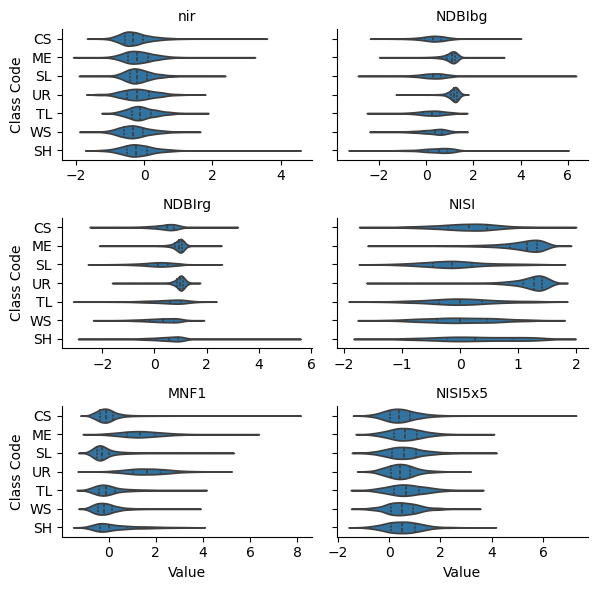

In [20]:
# Plot the distribution of abundances per material type by class
print(sampled_.columns.values)
print(sampled_['description'].unique())

new_cols = ['nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI5x5'] # removing the 27x27 texture

# Melt the DataFrame to long format
sampled_m = sampled_.melt(
    id_vars=['class_code'],
    value_vars=new_cols,
    var_name='Band',
    value_name='Value')

# Create a facet plot
g = sns.catplot(data=sampled_m, x='Value', y='class_code', col='Band',
                kind='violin', sharey=True, sharex=False, inner='quartile', 
                col_wrap=2, height=2, aspect=1.5)

# Adjusting the titles and axis labels (if needed)
g.set_titles("{col_name}")
g.set_axis_labels("Value", "Class Code")

# Save the plot


# Display the plot
plt.show()